In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from env import get_db_url

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_regression, RFE

In [2]:
url = get_db_url('telco_churn')

query = '''
SELECT * FROM customers
JOIN contract_types USING (contract_type_id)
JOIN internet_service_types USING (internet_service_type_id)
JOIN payment_types USING (payment_type_id)
'''
df_orig = pd.read_sql(query, url)

In [3]:
df = df_orig.copy()
#Encoding gender feature to be used later in modeling
df['gender_encoded'] = (df['gender'] == 'Male').astype(int)

In [4]:
df.tech_support.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64

In [5]:
#Creating single variable to represent if the user has 0, 1, or 
#more than 1 phone line, 0 being if the user has no phone service
df['number_of_lines'] = df.multiple_lines.replace({'Yes':2, 'No':1,\
                                        'No phone service':0})

df.drop(columns=['multiple_lines','phone_service'], inplace=True)

In [6]:
#Drop all total charges that are represented in the data with ' '.
df.total_charges.replace(' ', np.nan, inplace=True)
df.dropna(inplace=True)
df.total_charges = df.total_charges.astype(float)

#Encoding yes's and no's to be used later in modeling
df.replace('Yes', 1, inplace=True)
df.replace('No', 0, inplace=True)
df.replace('No internet service', 2, inplace=True)
df.replace('No phone service', 2, inplace=True)

In [7]:
#Creating new feature, which is tenure in whole years
df['tenure_years'] = (df.tenure / 12).astype(int)

In [8]:
# Sorting the columns by my preference
df = df[['customer_id', 'gender','gender_encoded','senior_citizen',
         'partner', 'dependents', 'number_of_lines',
         'online_security', 'online_backup', 'device_protection', 
         'tech_support', 'streaming_tv', 'streaming_movies', 
         'paperless_billing', 'tenure', 'tenure_years',
         'monthly_charges', 'total_charges', 'churn', 
         'payment_type', 'payment_type_id','internet_service_type', 
         'internet_service_type_id', 
         'contract_type', 'contract_type_id', ]]

In [9]:
# Split the data into train, test, and validate sets in order to 
# later evaluate our models
train, test = train_test_split(df, train_size = .8, random_state=42)
train, validate = train_test_split(train, train_size = .8, 
                                   random_state=42)

In [10]:
# Separate monthly charges into categorical bins to help 
# with modeling
train['monthly_charges_bins'] = pd.cut(train.monthly_charges, 
                [0,20,40,60,80,100,120],labels=[0,1,2,3,4,5])
pd.crosstab(train['churn'], train['monthly_charges_bins'],
            normalize='columns')

monthly_charges_bins,0,1,2,3,4,5
churn,,,,,,
0,0.900693,0.874505,0.730088,0.667371,0.620536,0.734513
1,0.099307,0.125495,0.269912,0.332629,0.379464,0.265487


In [11]:
validate['monthly_charges_bins'] = pd.cut(validate.monthly_charges, 
                [0,20,40,60,80,100,120],labels=[0,1,2,3,4,5])
test['monthly_charges_bins'] = pd.cut(test.monthly_charges, 
                [0,20,40,60,80,100,120],labels=[0,1,2,3,4,5])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
#Separate train data to use when scaling
#This drops non-numeric data
train_nums = train[['tenure','monthly_charges','total_charges']]
val_nums = validate[['tenure','monthly_charges','total_charges']]
test_nums = test[['tenure','monthly_charges','total_charges']]

In [13]:
train_nums.head(1)

,tenure,monthly_charges,total_charges
5217,63,98.0,6218.45


In [14]:
train[['monthly_charges','monthly_charges_bins']].sample(5)

,monthly_charges,monthly_charges_bins
5136,109.75,5
1991,57.50,2
6010,18.85,0
2472,84.25,4
4630,79.25,3


In [15]:
df.churn.mean()

0.26578498293515357

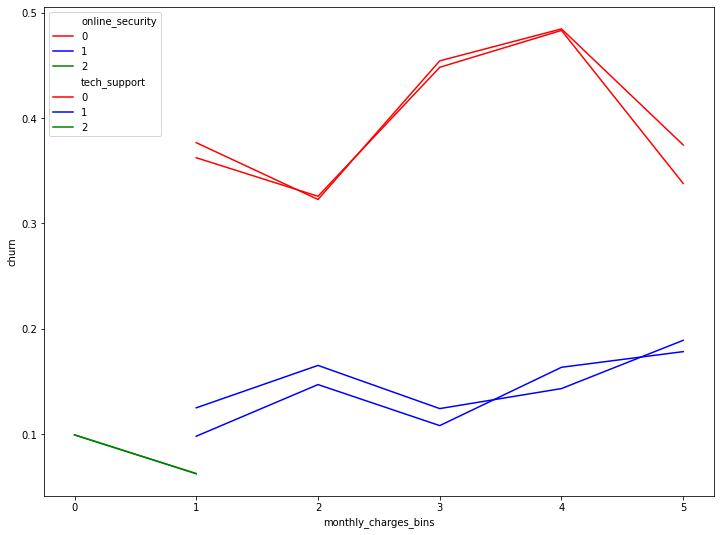

In [16]:
import warnings
warnings.simplefilter(action='ignore')
plt.rc('figure',figsize=(12,9))
sns.lineplot('monthly_charges_bins', 'churn', data = train, 
             err_style=None,
             hue='online_security', palette=['r','b','g'])
sns.lineplot('monthly_charges_bins', 'churn', data = train, 
             err_style=None,
             hue='tech_support', palette=['r','b','g'])

This shows that people who receive one or more of these 2 services are far less likely to churn than those who do not. We should devote at least some of our marketing to selling these services more often.

In [17]:
train[train.paperless_billing==0].churn.mean(),\
train[train.paperless_billing==1].churn.mean()

(0.1649142224681793, 0.3390271073152618)

This shows that people with paperless billing are twice as likely to churn as those without.

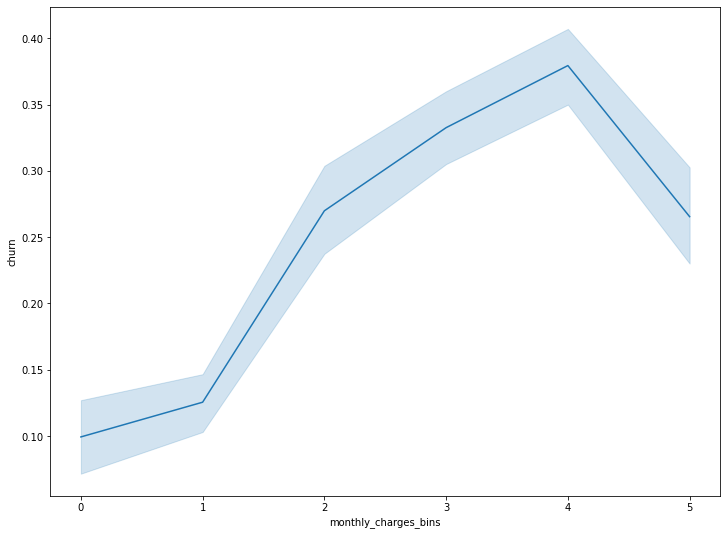

In [18]:
sns.lineplot(train.monthly_charges_bins, train.churn)

In [19]:
train[(train.monthly_charges_bins==3) |
     (train.monthly_charges_bins==4)].mean()

gender_encoded                 0.496855
senior_citizen                 0.220126
partner                        0.486212
dependents                     0.248670
number_of_lines                1.525399
online_security                0.328979
online_backup                  0.406386
device_protection              0.400581
tech_support                   0.338655
streaming_tv                   0.485244
streaming_movies               0.493469
paperless_billing              0.705854
tenure                        31.659410
tenure_years                   2.204161
monthly_charges               81.573682
total_charges               2613.868795
churn                          0.358007
payment_type_id                2.213353
internet_service_type_id       1.684567
contract_type_id               1.532172
dtype: float64

These numbers are interesting. In these two brackets of monthly charges, the churn rate averages almost 36%, rather than the total average of 26%. Looking deeper, we see that this demographic is very unlikely to be senior citizens or to have any dependents. We can target our marketing then towards childless adults. They are also less likely to be receiving tech support or online_security, both of which we already showed to have a correlation with churn rate, as well as a high chance of using paperless billing, which was also shown to be a large factor in churn.

In [20]:
train.monthly_charges_bins[train.number_of_lines==0].value_counts()

1    197
2    194
3     37
5      0
4      0
0      0
Name: monthly_charges_bins, dtype: int64

In [21]:
train.churn[train.number_of_lines==1]\
[train.monthly_charges_bins==2].count()

392

In [22]:
train.churn[train.number_of_lines==0]\
[train.monthly_charges_bins==3].sum()

1

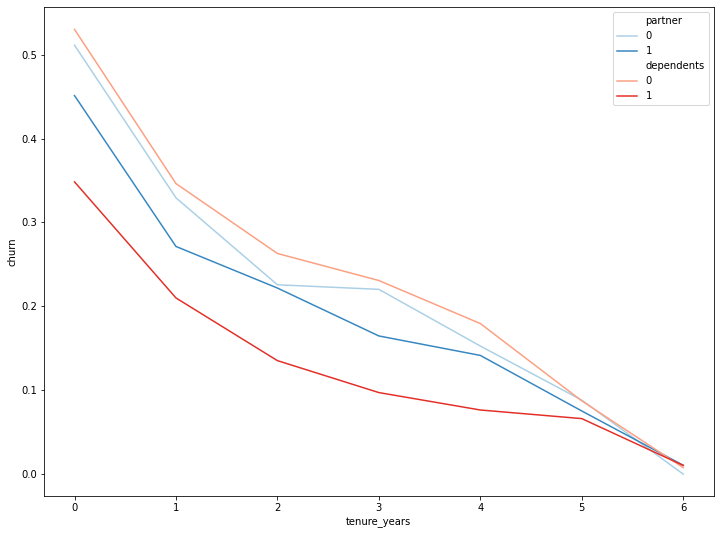

In [23]:
sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
             hue='partner', palette='Blues')
sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
             hue='dependents', palette='Reds')

This seems to say that the least likely group to churn of these 4 is that with dependents, only being matched by the other groups once tenure reaches more than 5 years. It also shows that having dependents is much more highly correlated with churn than having a partner.

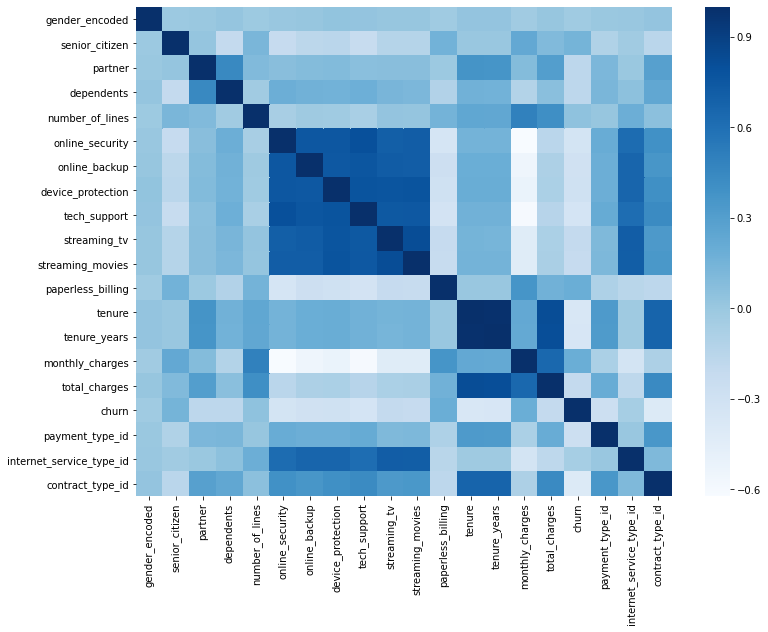

In [24]:
sns.heatmap(train.corr(), cmap='Blues')

This shows that the group of columns near the middle are closely correlated with each other, and therefore I believe only one should be used for modeling. This is obviously also true for tenure and tenure_years.

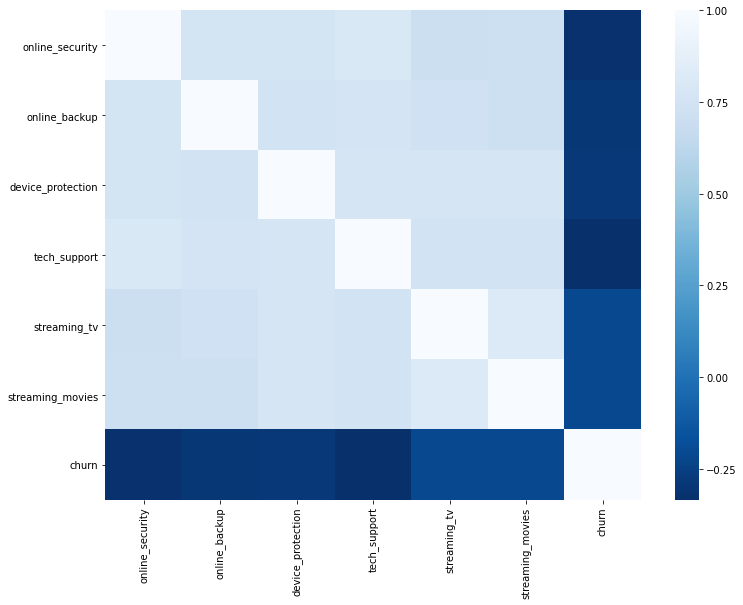

In [25]:
binary_features = train[['online_security','online_backup',
                   'device_protection', 'tech_support',
                   'streaming_tv','streaming_movies', 'churn']]
sns.heatmap(binary_features.corr(), cmap='Blues_r')

In [26]:
binary_features.corr().iloc[-1].nsmallest(2)

tech_support      -0.333430
online_security   -0.327007
Name: churn, dtype: float64

In [27]:
train.corr().iloc[16].sort_values()[0:8]

contract_type_id    -0.403699
tenure              -0.364808
tenure_years        -0.356645
tech_support        -0.333430
online_security     -0.327007
online_backup       -0.293977
device_protection   -0.289563
payment_type_id     -0.266530
Name: churn, dtype: float64

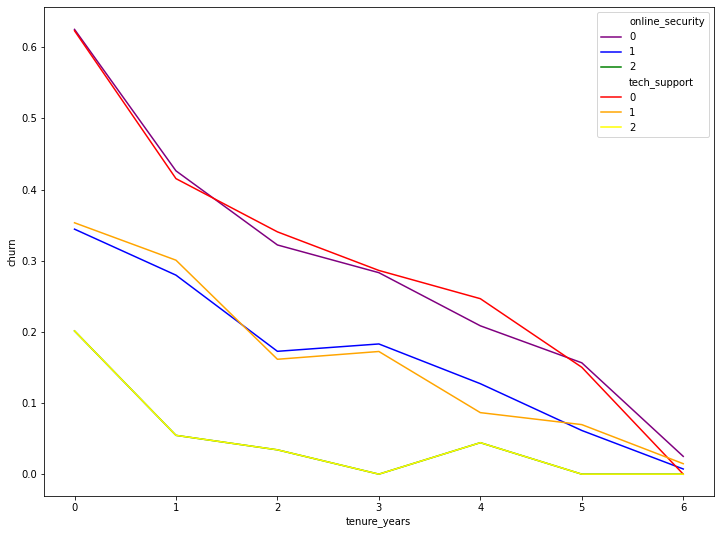

In [28]:
sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
        hue='online_security', palette=['Purple','Blue','Green'])
sns.lineplot('tenure_years', 'churn', data = train, err_style=None,
        hue='tech_support', palette=['Red','Orange','Yellow'])

This shows that the two most highly correlated of offered services are so similar that it barely makes a difference, so I will be choosing tech support, since that was slightly more correlated.

In [29]:
train.head()

,customer_id,gender,gender_encoded,senior_citizen,partner,dependents,number_of_lines,online_security,online_backup,device_protection,...,monthly_charges,total_charges,churn,payment_type,payment_type_id,internet_service_type,internet_service_type_id,contract_type,contract_type_id,monthly_charges_bins
5217,3134-DSHVC,Female,0,0,0,0,2,1,1,1,...,98.00,6218.45,0,Credit card (automatic),4,Fiber optic,2,Two year,3,4
5496,9586-JGQKH,Female,0,0,1,0,2,0,1,0,...,105.40,6794.75,0,Bank transfer (automatic),3,Fiber optic,2,Two year,3,5
4517,9874-QLCLH,Female,0,0,1,1,2,1,0,1,...,104.20,1743.50,1,Electronic check,1,Fiber optic,2,Month-to-month,1,5
5121,0835-JKADZ,Female,0,0,0,0,2,0,1,1,...,111.25,7984.15,0,Electronic check,1,Fiber optic,2,Two year,3,5
5322,5693-PIPCS,Male,1,0,0,0,1,0,1,0,...,99.65,4220.35,0,Credit card (automatic),4,Fiber optic,2,Two year,3,4


In [30]:
# From our earlier explorations these are the features I believe 
# to be the most likely to correctly predict churn rates
features = ['contract_type_id','tenure_years','tech_support',
            'payment_type_id','monthly_charges_bins','dependents',
           'paperless_billing']
X_train = train[features]
y_train = train.churn
X_val = validate[features]
y_val = validate.churn

In [31]:
sorted(features)

['contract_type_id',
 'dependents',
 'monthly_charges_bins',
 'paperless_billing',
 'payment_type_id',
 'tech_support',
 'tenure_years']

In [32]:
train_nums.columns

Index(['tenure', 'monthly_charges', 'total_charges'], dtype='object')

In [33]:
# This scales our numeric data to more easily be used in 
# modeling later
scaler = MinMaxScaler().fit(train_nums)
train_scaled = pd.DataFrame(scaler.transform(train_nums), 
                            columns = train_nums.columns.values)\
                            .set_index([train_nums.index.values])
val_scaled = pd.DataFrame(scaler.transform(val_nums), 
                            columns = val_nums.columns.values)\
                            .set_index([val_nums.index.values])

In [34]:
train_scaled.head()

,tenure,monthly_charges,total_charges
5217,0.873239,0.793532,0.716419
5496,0.887324,0.867164,0.783015
4517,0.225352,0.855224,0.199299
5121,0.985915,0.925373,0.920461
5322,0.563380,0.809950,0.485520


In [35]:
X_train_scaled = pd.concat([train_scaled,train[features]], axis=1)
y_train_scaled = train.churn
X_val_scaled = pd.concat([val_scaled,validate[features]], axis=1)
y_val_scaled = validate.churn

In [36]:
X_train_scaled.head()

,tenure,monthly_charges,total_charges,contract_type_id,tenure_years,tech_support,payment_type_id,monthly_charges_bins,dependents,paperless_billing
5217,0.873239,0.793532,0.716419,3,5,0,4,4,0,0
5496,0.887324,0.867164,0.783015,3,5,1,3,5,0,1
4517,0.225352,0.855224,0.199299,1,1,0,1,5,1,1
5121,0.985915,0.925373,0.920461,3,5,1,1,5,0,1
5322,0.563380,0.809950,0.485520,3,3,1,4,4,0,1


In [37]:
model_lr = LogisticRegression(random_state=42).fit(X_train, y_train)
model_lr.score(X_train, y_train), model_lr.score(X_val, y_val)

(0.7971111111111111, 0.7875555555555556)

In [38]:
ypred_lr = model_lr.predict(X_train)
print(classification_report(train.churn, ypred_lr))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3289
           1       0.65      0.53      0.59      1211

    accuracy                           0.80      4500
   macro avg       0.74      0.71      0.73      4500
weighted avg       0.79      0.80      0.79      4500



In [39]:
model_dt = DecisionTreeClassifier(max_depth=3, random_state=42)\
      .fit(X_train, y_train)
model_dt.score(X_train, y_train), model_dt.score(X_val, y_val)

(0.7797777777777778, 0.7697777777777778)

In [40]:
ypred_dt = model_dt.predict(X_train)
print(classification_report(train.churn, ypred_dt))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3289
           1       0.63      0.44      0.52      1211

    accuracy                           0.78      4500
   macro avg       0.72      0.67      0.69      4500
weighted avg       0.76      0.78      0.77      4500



In [41]:
ypred_dt = model_dt.predict(X_val)
print(classification_report(validate.churn, ypred_dt))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       823
           1       0.61      0.40      0.48       302

    accuracy                           0.77      1125
   macro avg       0.71      0.65      0.67      1125
weighted avg       0.75      0.77      0.75      1125



In [42]:
model_rf = RandomForestClassifier(random_state=42, 
                            min_samples_leaf = 3,
                            max_depth = 5).fit(X_train, y_train)
model_rf.score(X_train, y_train), model_rf.score(X_val, y_val)

(0.8013333333333333, 0.7795555555555556)

In [43]:
ypred_rf = model_rf.predict(X_train)
print(classification_report(train.churn, ypred_rf))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3289
           1       0.68      0.49      0.57      1211

    accuracy                           0.80      4500
   macro avg       0.76      0.70      0.72      4500
weighted avg       0.79      0.80      0.79      4500



In [44]:
ypred_rf = model_rf.predict(X_val)
print(classification_report(validate.churn, ypred_rf))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       823
           1       0.64      0.42      0.51       302

    accuracy                           0.78      1125
   macro avg       0.72      0.67      0.68      1125
weighted avg       0.76      0.78      0.76      1125



In [45]:
model_kn = KNeighborsClassifier().fit(X_train, y_train)
model_kn.score(X_train, y_train), model_kn.score(X_val, y_val)

(0.8086666666666666, 0.7706666666666667)

In [46]:
ypred_kn = model_kn.predict(X_train)
print(classification_report(train.churn, ypred_kn))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3289
           1       0.65      0.61      0.63      1211

    accuracy                           0.81      4500
   macro avg       0.76      0.75      0.75      4500
weighted avg       0.81      0.81      0.81      4500



In [47]:
ypred_kn = model_kn.predict(X_val)
print(classification_report(validate.churn, ypred_kn))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       823
           1       0.58      0.53      0.56       302

    accuracy                           0.77      1125
   macro avg       0.71      0.70      0.70      1125
weighted avg       0.77      0.77      0.77      1125



In [48]:
model_kn_scaled = KNeighborsClassifier().fit(X_train_scaled, 
                                       y_train_scaled)
model_kn_scaled.score(X_train_scaled, y_train_scaled),\
model_kn_scaled.score(X_val_scaled, y_val_scaled)

(0.8448888888888889, 0.7582222222222222)

In [49]:
ypred_kn_scaled = model_kn_scaled.predict(X_train_scaled)
print(classification_report(train.churn, ypred_kn_scaled))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3289
           1       0.74      0.65      0.69      1211

    accuracy                           0.84      4500
   macro avg       0.81      0.78      0.79      4500
weighted avg       0.84      0.84      0.84      4500



In [50]:
ypred_kn_scaled = model_kn_scaled.predict(X_val_scaled)
print(classification_report(validate.churn, ypred_kn_scaled))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       823
           1       0.56      0.48      0.51       302

    accuracy                           0.76      1125
   macro avg       0.69      0.67      0.68      1125
weighted avg       0.75      0.76      0.75      1125



If we consider churn to be our positive, then there is a higher cost of false negatives since we would lose a customer that we predicted we would stay, rather than perhaps giving some kind of reward or discount to someone who would have stayed regardless. If that is the case, then a high recall should be our focus.

Looking at the reports for all the models we tested, random forest gave us the highest recall, so that is the model I would choose to go with in the future for new data.